In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA, FastICA
import seaborn as sns
from lib.data import semi_empirical_mass_formula, BW2_mass_formula
sns.set_style('darkgrid')
sns.set_context('paper')

In [2]:
# location = f"{IO.get_root()}/all_0_extrap_2_20k"
# location = f"{IO.get_root()}/all_0_extrap_1_20k_no_zn"
# location = f"{IO.get_root()}/all_0_extrap_1_20k_no_zn_4depth"
location = f"{IO.get_root()}/all_0_extrap_1_25k_no_zn_4depth_per_nucleon_weightsbinding_bw2"

args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
new_model = get_model_and_optim(data, args)[0]
new_model.load_state_dict(torch.load(IO.load_latest_model(location)))
model_name = location.split('/')[-2]

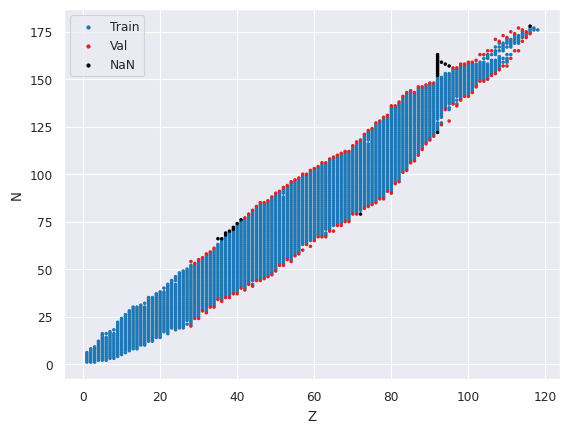

In [3]:
for mask, c in zip([data.train_mask, data.val_mask], ['C0', 'C3']):
    mask = mask & (data.X[:, 2] == 0)
    X = data.X[mask].cpu()
    y = data.y[mask].cpu()
    c = ['k' if y[i].isnan() else c for i in range(len(y))]
    plt.scatter(X[:, 0], X[:, 1], c=c, s=3)
plt.xlabel('Z')
plt.ylabel('N')
# legend for train, val, nan 
# first create the the points for the legend
legend_elements = [plt.scatter([], [], c='C0', s=5, label='Train')]
legend_elements += [plt.scatter([], [], c='C3', s=5, label='Val')]
legend_elements += [plt.scatter([], [], c='k', s=5, label='NaN')]
plt.legend(handles=legend_elements)

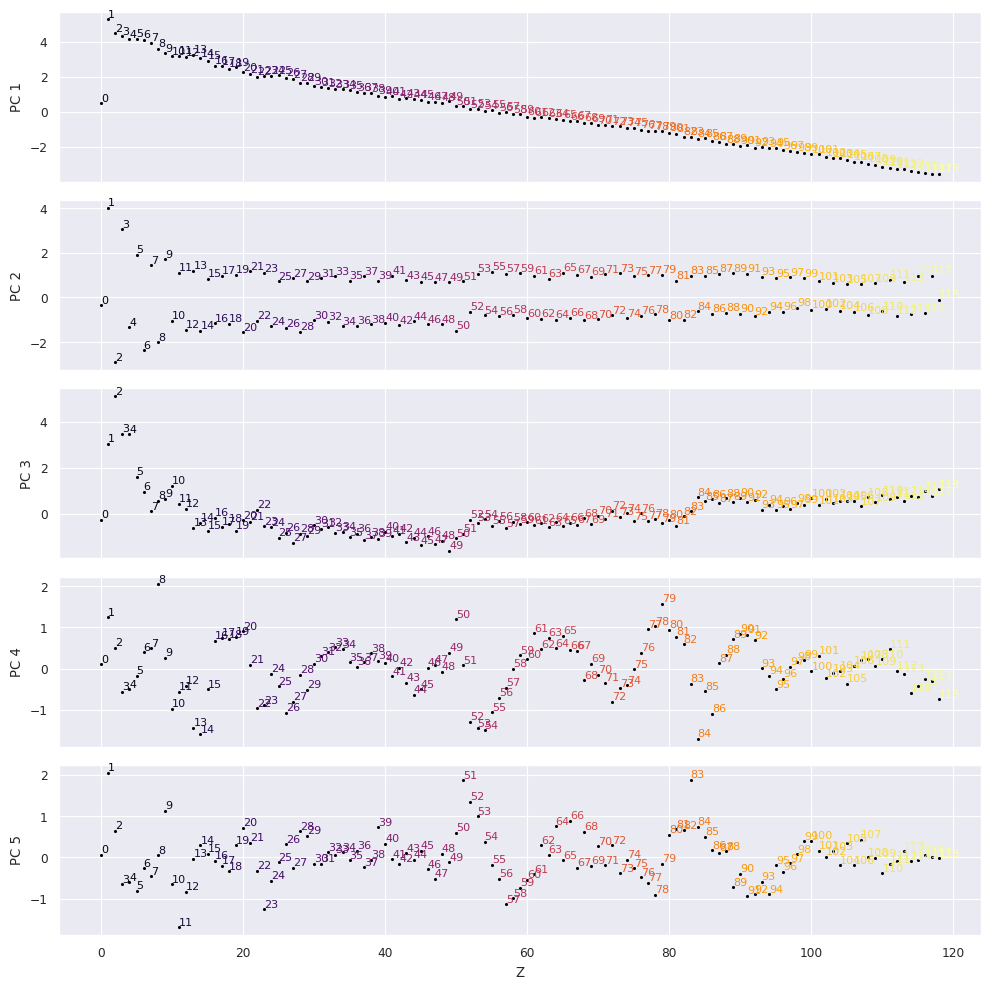

In [4]:
# let's take a look at our embeddings
for i, nucleon in enumerate(["Z", "N"]):
    embed = new_model.emb[i].detach().cpu().numpy()

    # pca = FastICA(n_components=(n_components:=5), fun='cube')
    pca = PCA(n_components=(n_components:=5))
    embed = pca.fit_transform(embed)
    colors = plt.cm.inferno(np.linspace(0, 1, len(embed)))

    fig, axes = plt.subplots(n_components, 1, figsize=(10, n_components*2), sharex=True)
    axes = axes.flatten()
    for i in range(0, n_components):
        ax = axes[i]
        x, y = np.arange(len(embed)), embed[:, i]
        ax.scatter(x, y, s=2, c='k')
        PlottingContext.scatter_text(np.arange(len(embed)), x, y, colors=colors, ax=ax, fontsize=8)
        ax.set_ylabel(f"PC {i+1}")

    ax.set_xlabel(nucleon)
    fig.tight_layout()
    # plt.savefig(f"plots/paper/new_{model_name}_embeddings_{nucleon}.pdf")
    plt.show()
    break

In [5]:
X_train = data.X[~torch.isnan(data.y).view(-1) & data.train_mask]
y_train = data.y[~torch.isnan(data.y).view(-1) & data.train_mask]

X_val = data.X[~torch.isnan(data.y).view(-1) & data.val_mask]
y_val = data.y[~torch.isnan(data.y).view(-1) & data.val_mask]

X_train, y_train = X_train[X_train[:, 2] == 0],  y_train[X_train[:, 2] == 0] 
X_val, y_val = X_val[X_val[:, 2] == 0],  y_val[X_val[:, 2] == 0]

unc_val = data.binding_unc[(~torch.isnan(data.y).view(-1) & data.val_mask)[data.X[:, 2] == 0]]
unc_train = data.binding_unc[(~torch.isnan(data.y).view(-1) & data.train_mask)[data.X[:, 2] == 0]]

In [6]:
# Save the last layer activations
train = False 
X = X_train  if train else X_val
y = y_train if train else y_val

acts = torch.zeros(len(X), 2048)
# save the activations fed into the readout layer
hook = new_model.readout.register_forward_pre_hook(lambda m, i: acts.copy_(i[0].detach()))
new_model(X)
hook.remove()

def inverse_transform(vector, index):
    """inverse transform the vector to the original scale"""
    scale = data.regression_transformer.data_max_[index] - data.regression_transformer.data_min_[index]
    min_ = data.regression_transformer.data_min_[index]
    vector = vector * scale + min_
    return vector

# Ensure that the RMS is the same as the franken model
def get_preds_from_last_acts(acts):
    preds = new_model.readout(acts) 
    preds = preds.detach().cpu().numpy()
    preds = data.regression_transformer.inverse_transform(preds)
    return preds[:, 0]

def get_rms_from_last_acts(acts):
    preds = get_preds_from_last_acts(acts)
    targets = y.detach().cpu().numpy().reshape(-1)
    # targets = inverse_transform(targets, 0)
    zn = X[:, :2].detach().cpu().numpy()
    rms = get_rms(preds, targets, zn, scale_by_A=args.PER_NUCLEON == 'true')
    return rms
print(f"RMS recomputed: {get_rms_from_last_acts(acts):.2f}")

RMS recomputed: 875.64


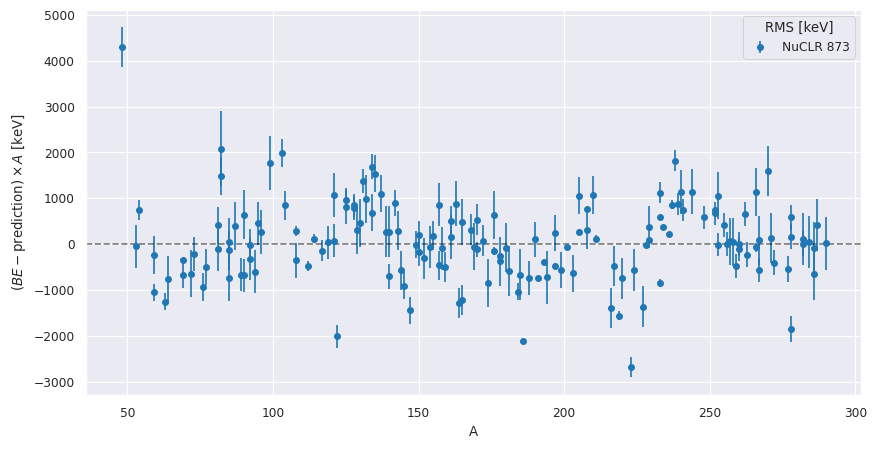

In [7]:
# let's make a plot to showcase where the model is making mistakes
zn = X_val[:, :2].detach().cpu().numpy()
preds = inverse_transform(new_model(X_val).detach().cpu().numpy()[:, 0], 0)
targets = y_val.detach().cpu().numpy().reshape(-1) 
# targets = inverse_transform(targets, 0)
s = ((unc_val).detach().cpu().numpy().reshape(-1) )
mask = (zn[:, 0] < zn[:, 0].max()) &  (zn[:, 1] < zn[:, 1].max()-1)
preds = preds[mask] 
targets = targets[mask]
zn = zn[mask]
s = s[mask]

rms = get_rms(preds, targets, zn, scale_by_A=args.PER_NUCLEON == 'true')

fig, ax = plt.subplots(figsize=(10, 5))
x_axis = zn.sum(axis=1)
# ax.scatter(targets, preds, s=s, c='C0',)
targets_scaled, preds_scaled, s_scaled = targets * zn.sum(axis=1), preds * zn.sum(axis=1), s * zn.sum(axis=1)
ax.errorbar( x_axis, targets_scaled - preds_scaled, yerr=s_scaled, c='C0',fmt='o', markersize=4, label=f'NuCLR {rms:.0f}')
ax.set_ylabel(r"$(BE - \mathrm{prediction})\times A$ [keV]")
ax.set_xlabel("A")
plt.axhline(0, c='k', ls='--', alpha=0.5)

# RMS of the physics models
preds_semf = semi_empirical_mass_formula(zn[:, 0], zn[:, 1]) * zn.sum(axis=1)
semf_rms = ((preds_semf - targets_scaled)**2).mean()**0.5
preds_bw2 = BW2_mass_formula(zn[:, 0], zn[:, 1]) * zn.sum(axis=1)
bw2_rms = ((preds_bw2 - targets_scaled)**2).mean()**0.5

# plt.scatter(x_axis, targets_scaled - preds_semf, c='C1', label=f'SEMF   {semf_rms:.0f}')
# plt.scatter(x_axis, targets_scaled - preds_bw2, c='C2', label=f'BW2    {bw2_rms:.0f}')
plt.legend(title="RMS [keV]")
plt.show()

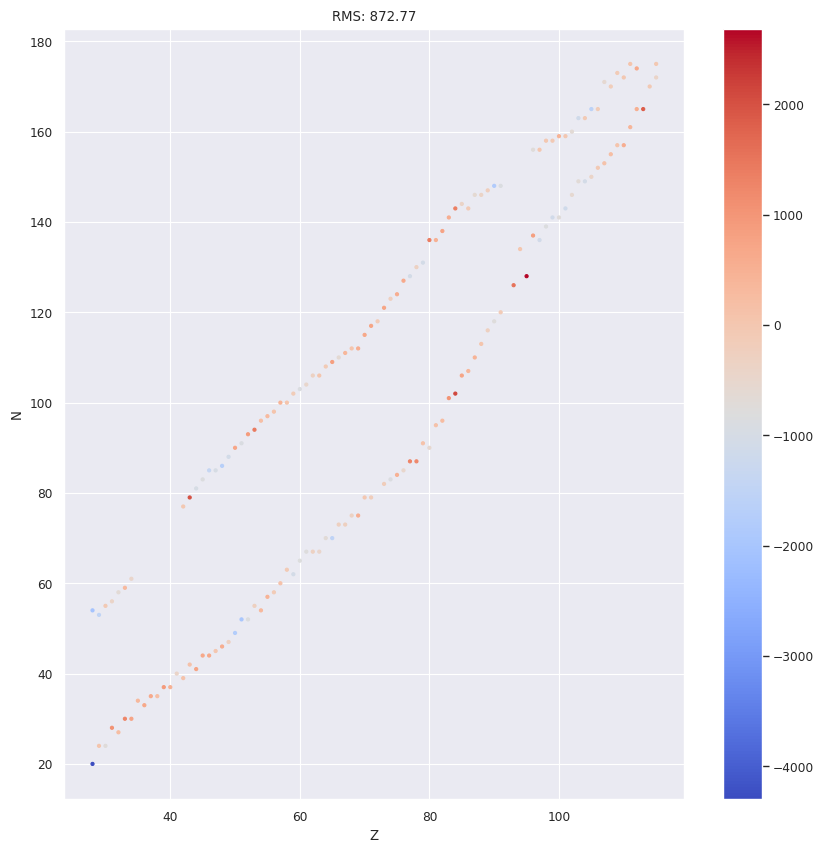

In [8]:
# now let's make the residual plot in 2D
fig, ax = plt.subplots(figsize=(10, 10))
sc = ax.scatter(zn[:, 0], zn[:, 1], s=5, c=preds_scaled-targets_scaled, cmap='coolwarm')
ax.set_xlabel("Z")
ax.set_ylabel("N")
ax.set_title(f"RMS: {rms:.2f}")
fig.colorbar(sc)